In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
from geopy.distance import geodesic

In [2]:
# Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# ✅ PostgreSQL 연결 정보
DB_HOST = "localhost"   # DB ip 주소로 변경해야 함
DB_PORT = "5432"
DB_NAME = "ais_data"
DB_USER = "postgres"
DB_PASS = "ky76018500"

In [3]:
# ✅ 특정 시간 기준 3시간치 데이터 가져오기
# 분석할 기준 시간 설정
start_time = "2020-03-03 00:00:00" 
end_time = "2020-03-03 03:00:00"
query = f"""
SELECT mmsi, timestamp, latitude, longitude, sog, cog, heading 
FROM ais
WHERE timestamp BETWEEN '{start_time}' AND '{end_time}';
"""
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
df = pd.read_sql(query, engine)

In [4]:
# ✅ 컬럼명 변환
df.rename(columns={"timestamp": "datetime"}, inplace=True)

# ✅ 데이터 타입 변환
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.astype({
    "mmsi": "string",
    "latitude": "float32", "longitude": "float32",
    "sog": "float32", "cog": "float32", "heading": "float32"
})

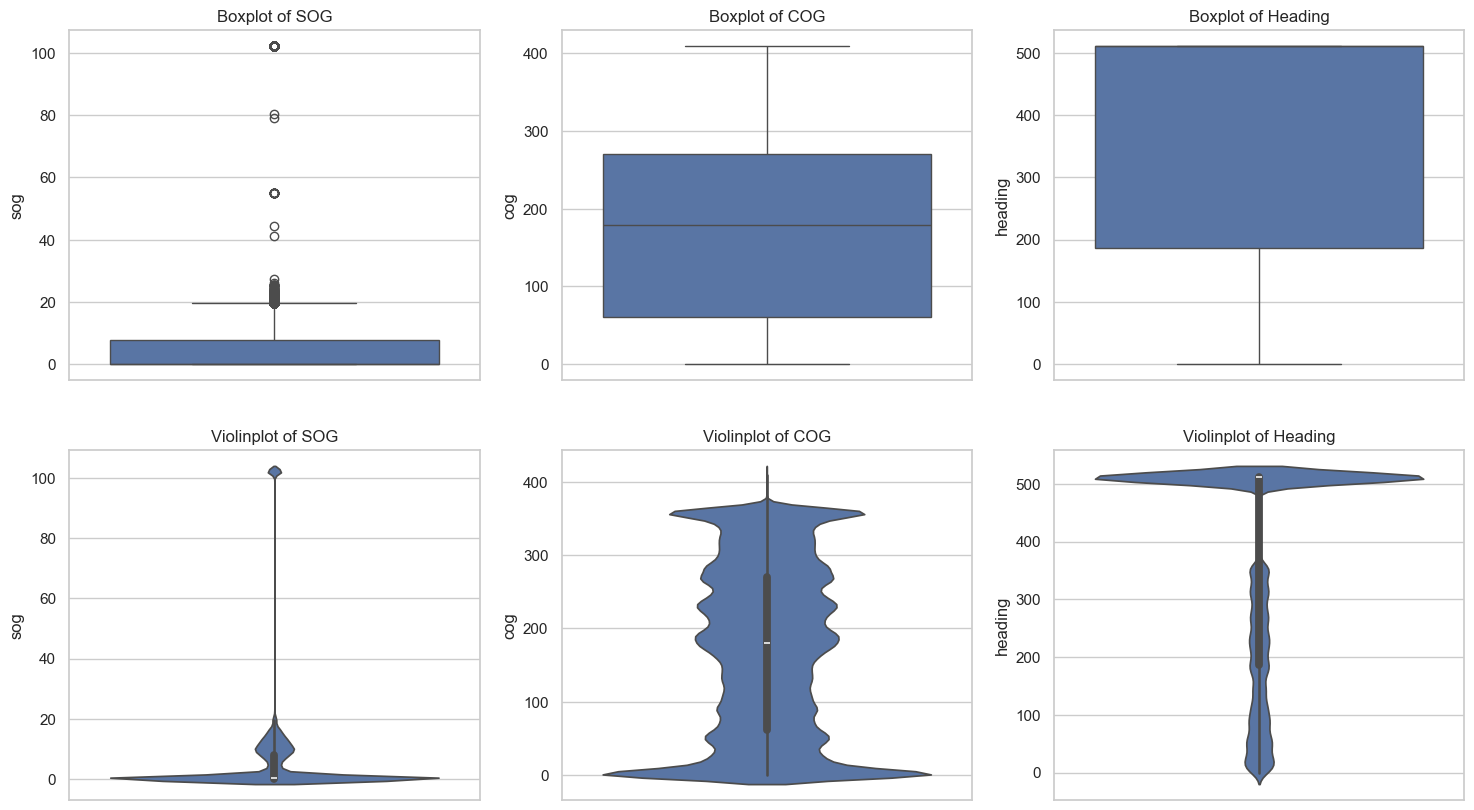

In [5]:
# ✅ 1. SOG, COG, Heading 이상치 탐색 (Boxplot & Violinplot)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.boxplot(y=df["sog"], ax=axes[0, 0])
axes[0, 0].set_title("Boxplot of SOG")

sns.boxplot(y=df["cog"], ax=axes[0, 1])
axes[0, 1].set_title("Boxplot of COG")

sns.boxplot(y=df["heading"], ax=axes[0, 2])
axes[0, 2].set_title("Boxplot of Heading")

sns.violinplot(y=df["sog"], ax=axes[1, 0])
axes[1, 0].set_title("Violinplot of SOG")

sns.violinplot(y=df["cog"], ax=axes[1, 1])
axes[1, 1].set_title("Violinplot of COG")

sns.violinplot(y=df["heading"], ax=axes[1, 2])
axes[1, 2].set_title("Violinplot of Heading")

plt.show()

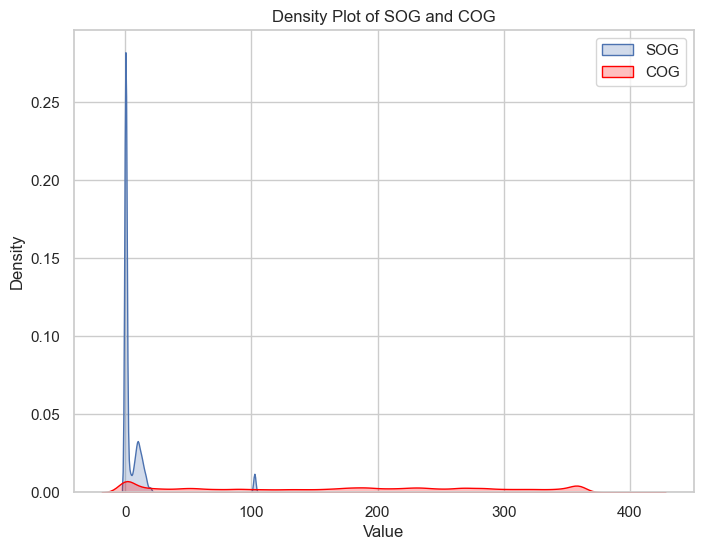

In [6]:
# ✅ 2. SOG & COG 밀도 분포 확인 (KDE Plot)
plt.figure(figsize=(8, 6))
sns.kdeplot(df["sog"], fill=True, label="SOG")
sns.kdeplot(df["cog"], fill=True, label="COG", color='red')
plt.title("Density Plot of SOG and COG")
plt.xlabel("Value")
plt.legend()
plt.show()

C:\Users\kyb87\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


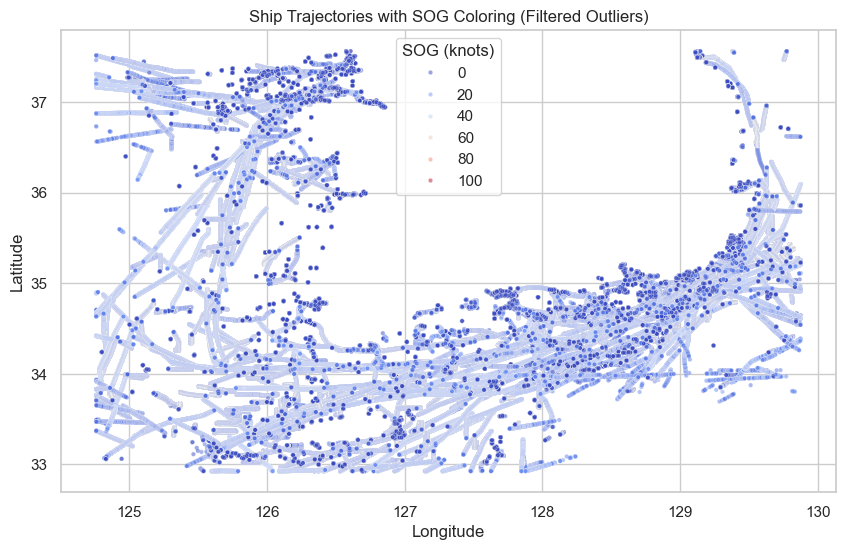

In [7]:
# ✅ 3. 선박 항로 패턴 분석 (Trajectory Plot, 이상치 생략)
plt.figure(figsize=(10, 6))
threshold = np.percentile(df[["latitude", "longitude"]], [2, 95], axis=0)  # 2~95 퍼센트 구간만 시각화
filtered_df = df[(df["latitude"] > threshold[0, 0]) & (df["latitude"] < threshold[1, 0]) &
                 (df["longitude"] > threshold[0, 1]) & (df["longitude"] < threshold[1, 1])]

sns.scatterplot(x=filtered_df["longitude"], y=filtered_df["latitude"], hue=filtered_df["sog"], 
                palette="coolwarm", alpha=0.5, s=10)
plt.title("Ship Trajectories with SOG Coloring (Filtered Outliers)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="SOG (knots)")
plt.show()

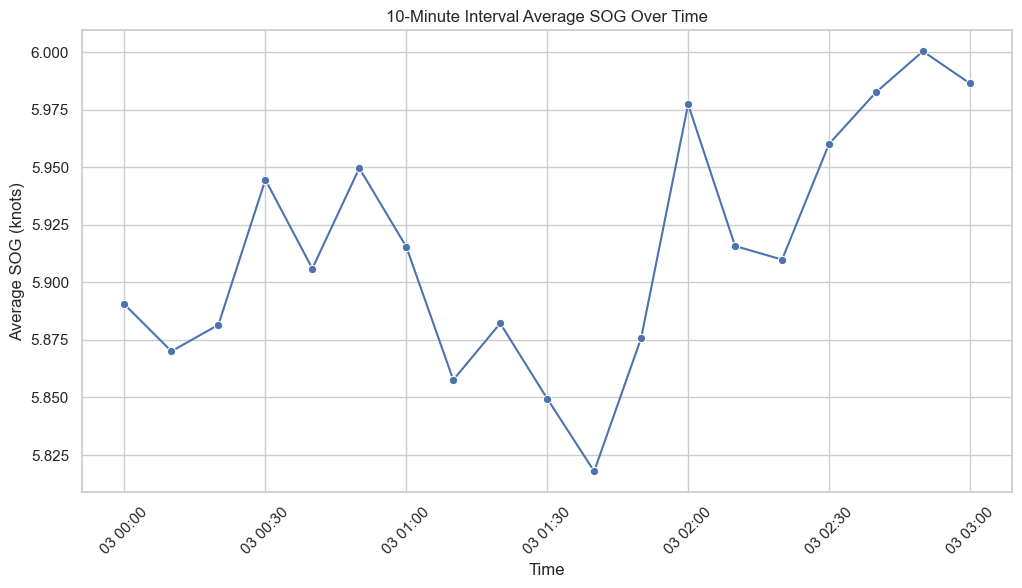

In [8]:
# ✅ 4. 10분 단위 SOG 평균 분석
df["time_10min"] = df["datetime"].dt.round("10min")  # 10분 단위로 반올림하여 그룹화
sog_avg = df.groupby("time_10min", as_index=False)["sog"].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=sog_avg, x="time_10min", y="sog", marker="o", linestyle="-", color="b")
plt.title("10-Minute Interval Average SOG Over Time")
plt.xlabel("Time")
plt.ylabel("Average SOG (knots)")
plt.xticks(rotation=45)
plt.show()

C:\Users\kyb87\AppData\Local\Temp\ipykernel_13136\3221502366.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  distance_df = df.groupby("mmsi").apply(calculate_distance).reset_index()


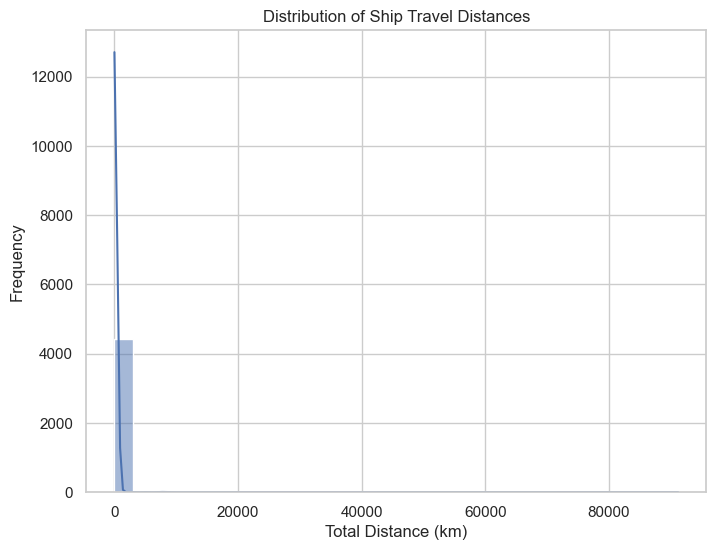

In [9]:
# ✅ 5. 새로운 분석 방식: MMSI별 이동 거리 분포
def calculate_distance(group):
    coords = list(zip(group["latitude"], group["longitude"]))
    distances = [geodesic(coords[i], coords[i+1]).km for i in range(len(coords)-1)]
    return np.sum(distances)

# ✅ 위도(latitude)는 [-90, 90] 범위, 경도(longitude)는 [-180, 180] 범위로 필터링
df = df[(df["latitude"].between(-90, 90)) & (df["longitude"].between(-180, 180))]
distance_df = df.groupby("mmsi").apply(calculate_distance).reset_index()
distance_df.columns = ["mmsi", "total_distance_km"]

plt.figure(figsize=(8, 6))
sns.histplot(distance_df["total_distance_km"], bins=30, kde=True)
plt.title("Distribution of Ship Travel Distances")
plt.xlabel("Total Distance (km)")
plt.ylabel("Frequency")
plt.show()

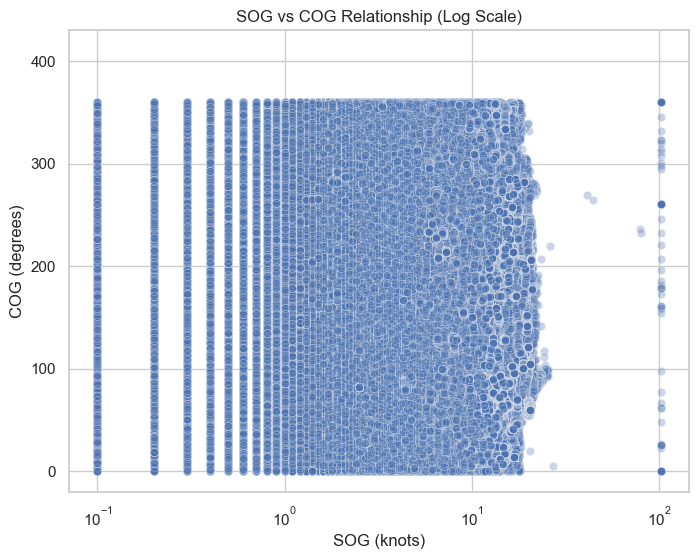

In [10]:
# ✅ 6. SOG vs COG 관계 분석 (Scatter Plot + Log Scale)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["sog"], y=df["cog"], alpha=0.3)
plt.xscale("log")  # 데이터 분포 균형 조정
plt.title("SOG vs COG Relationship (Log Scale)")
plt.xlabel("SOG (knots)")
plt.ylabel("COG (degrees)")
plt.show()

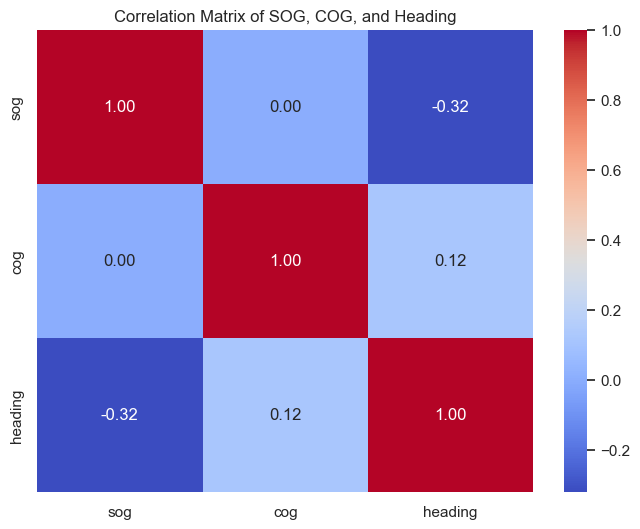

In [11]:
# ✅ 7. 변수 간 상관관계 분석 (Correlation Heatmap)
plt.figure(figsize=(8, 6))
corr_matrix = df[["sog", "cog", "heading"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of SOG, COG, and Heading")
plt.show()